In [1]:
import pandas as pd
import numpy as np
import nupic
import matplotlib.pyplot as plt 
import time

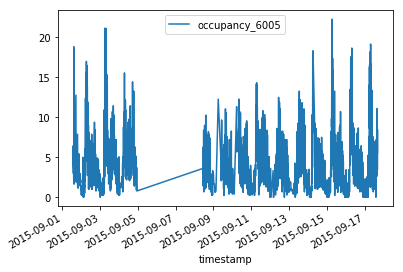

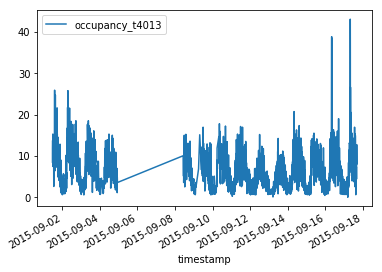

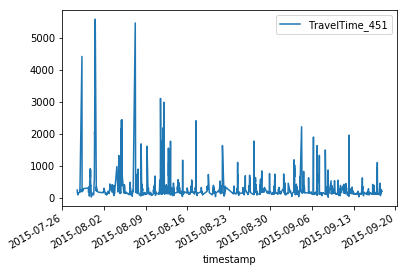

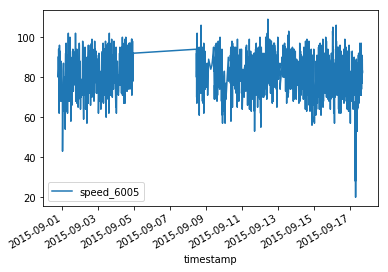

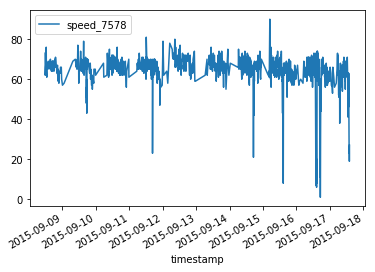

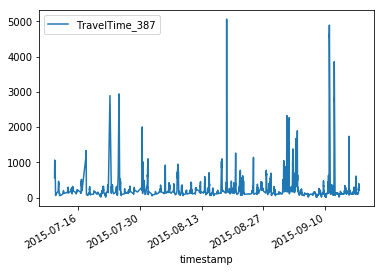

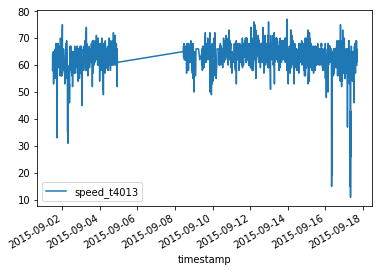

In [2]:
s = set() 
s.add('occupancy_6005')
s.add('occupancy_t4013')
s.add('speed_6005')
s.add('speed_7578')
s.add('speed_t4013')
s.add('TravelTime_387')
s.add('TravelTime_451')

for x in s:
    exec(x + " = pd.read_csv('" + x + ".csv', parse_dates=True, index_col='timestamp')")
    
for x in s:
    exec(x +" = " + x + ".rename(columns={'value': x})")
    
for x in s:
    exec(x +".plot()")
   

In [3]:
for x in s:
    exec(x + " = " + x + ".resample('H').mean()")

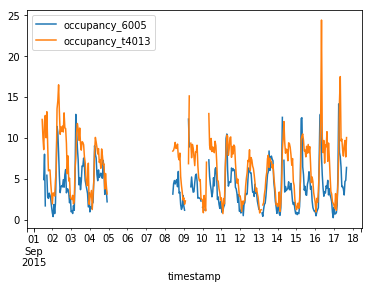

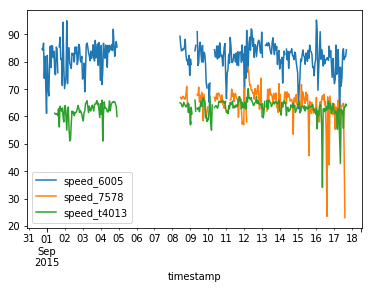

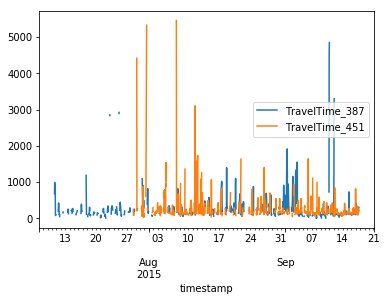

In [4]:
occ = pd.concat([occupancy_6005, occupancy_t4013], axis = 1)
spd = pd.concat([speed_6005, speed_7578, speed_t4013], axis = 1)
tti = pd.concat([TravelTime_387, TravelTime_451], axis = 1)
occ.plot()
spd.plot()
tti.plot()

# NuPIC HTM Implementation

In [5]:
#Import from NuPIC library
from nupic.encoders import RandomDistributedScalarEncoder
from nupic.algorithms.spatial_pooler import SpatialPooler
from nupic.algorithms.temporal_memory import TemporalMemory
from nupic.algorithms.anomaly import Anomaly 


In [6]:

data_all = pd.concat([occupancy_6005, occupancy_t4013, speed_6005, speed_7578, speed_t4013], axis = 1)
dataseq = data_all.resample('H').bfill().interpolate()
import datetime as dt # Imports dates library 
a = dt.datetime(2015, 9, 8, 12) # Fixes the start date 
seldata = dataseq[a:] # Subsets the data

In [7]:
Vars = set(["occupancy_6005", "occupancy_t4013", "speed_6005", "speed_7578", "speed_t4013"])

In [8]:
for x in Vars:
    exec("RDSE_"+ x +" = RandomDistributedScalarEncoder(resolution=seldata['"+ x +"'].std()/5)")

In [9]:
prueba = seldata['speed_6005']

In [10]:
seldata['speed_6005'][0]

84.0

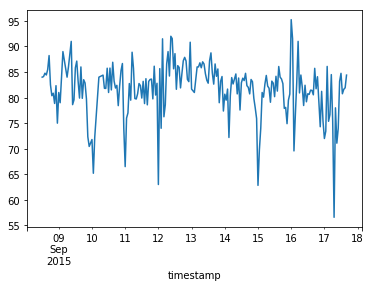

In [11]:
prueba.plot()

### Encoding

Es importante fijar la precisión adecuada para discernir los cambios requeridos en las variables <br>
- En nuestro caso hemos probado con $ ^\sigma / _5$ <br>

Se ha de comprobar que efectivamente las diferencias en los encoders son signidicativas cuando lo son para las variables que se han tomado

In [12]:
RDSE = RandomDistributedScalarEncoder(resolution=prueba.std()/5)

In [13]:
a = np.zeros(len(prueba)-1)
for x in range(len(prueba)-1):
    a[x] = sum(RDSE.encode(prueba[x]) != RDSE.encode(prueba[x-1]))

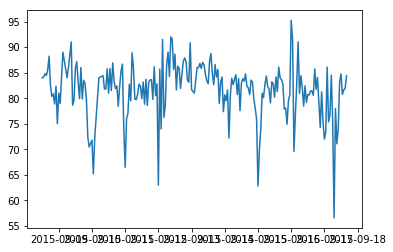

In [14]:
plt.plot(prueba)

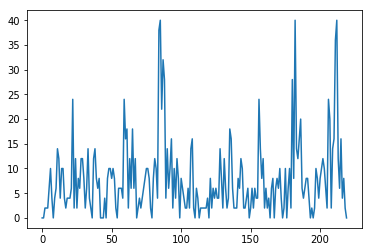

In [15]:
plt.plot(a)

Spatial pooler

In [16]:
# Define the imput width 
encoder_width = RDSE.getWidth()
pooler_out = 2048

In [17]:
encoder_width = 0 
for x in Vars:
    exec("encoder_width += RDSE_"+ x +".getWidth()")
pooler_out = 4096

In [19]:
sp = SpatialPooler(
    # How large the imput encoding will be
    inputDimensions=(encoder_width), 
    # Number of columns on the Spatial Pooler
    columnDimensions=(pooler_out),
    # Percent of the imputs that a column can be conected to, 1 means the colum is connected to every other column
    potentialPct = 0.8,
    # Eliminates the topology 
    globalInhibition = True,
    # Recall that there is only one inhibition area
    numActiveColumnsPerInhArea = pooler_out//50,
    #Velocity of synapses grown an degradation
    synPermInactiveDec = 0.005,
    synPermActiveInc = 0.04,
    synPermConnected = 0.1,
    # boostStrength controls the strength of boosting. Boosting encourages efficient usage of SP columns.
    boostStrength = 3.0,
    seed = 25,
    # Determines whether the encoder is cyclic or not
    wrapAround = False)

In [67]:
activeColumns = np.zeros(pooler_out)

encoding = RDSE.encode(prueba[0])

sp.compute(encoding, True, activeColumns)
activeColumnIndices = np.nonzero(activeColumns)[0]

print activeColumnIndices
plt.plot(activeColumns)

ValueError: Input vector dimensions don't match. Expecting 400 but got 2000

In [20]:
tm = TemporalMemory(
  # Must be the same dimensions as the SP
  columnDimensions=(pooler_out,),
  # How many cells in each mini-column.
  cellsPerColumn=5,
  # A segment is active if it has >= activationThreshold connected synapses that are active due to infActiveState
  activationThreshold=16,
  initialPermanence=0.21,
  connectedPermanence=0.5,
  # Minimum number of active synapses for a segment to be considered during
  # search for the best-matching segments.
  minThreshold=12,
  # The max number of synapses added to a segment during learning
  maxNewSynapseCount=20,
  permanenceIncrement=0.1,
  permanenceDecrement=0.1,
  predictedSegmentDecrement=0.0,
  maxSegmentsPerCell=128,
  maxSynapsesPerSegment=32,
  seed=25)

In [31]:
# Execute Temporal Memory algorithm over active mini-columns.
tm.compute(activeColumnIndices, learn=True)
activeCells = tm.getActiveCells()
print activeCells

[2070, 2071, 2072, 2073, 2074, 2110, 2111, 2112, 2113, 2114, 2120, 2121, 2122, 2123, 2124, 2155, 2156, 2157, 2158, 2159, 2165, 2166, 2167, 2168, 2169, 2175, 2176, 2177, 2178, 2179, 2235, 2236, 2237, 2238, 2239, 2285, 2286, 2287, 2288, 2289, 2370, 2371, 2372, 2373, 2374, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2720, 2721, 2722, 2723, 2724, 2780, 2781, 2782, 2783, 2784, 2975, 2976, 2977, 2978, 2979, 7725, 7726, 7727, 7728, 7729, 7735, 7736, 7737, 7738, 7739, 7755, 7756, 7757, 7758, 7759, 7760, 7761, 7762, 7763, 7764, 7800, 7801, 7802, 7803, 7804, 7810, 7811, 7812, 7813, 7814, 7885, 7886, 7887, 7888, 7889, 7905, 7906, 7907, 7908, 7909, 7940, 7941, 7942, 7943, 7944, 7945, 7946, 7947, 7948, 7949, 7950, 7951, 7952, 7953, 7954, 8880, 8881, 8882, 8883, 8884, 8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8910, 8911, 8912, 8913, 8914, 8925, 8926, 8927, 8928, 8929, 8930, 8931, 8932, 8933, 8934, 8945, 8946, 8947, 8948, 8949, 8955, 8956, 8957, 8958, 8959, 9010, 901

Univariate procedure

In [21]:
activeColumns = np.zeros(pooler_out)

from __future__ import division

A_score = np.zeros(len(prueba))

for x in range(len(prueba)):
    encoding = RDSE.encode(prueba[x]) #encode each input value
    sp.compute(encoding, False, activeColumns) #Spatial Pooler
    activeColumnIndices = np.nonzero(activeColumns)[0]
    tm.compute(activeColumnIndices, learn=True)
    activeCells = tm.getActiveCells()
    if x > 0:
        inter = set(activeColumnIndices).intersection(predictiveColumns_prev)
        inter_l = len(inter)
        active_l = len(activeColumnIndices)
        A_score[x] = 1 - (inter_l/active_l)
                                     
    predictiveColumns_prev = list(set([x//5 for x in tm.getPredictiveCells()]))
    #print ("intersección ", inter_l, ", Activas ", active_l, " cociente ", inter_l/active_l)

    

    

ValueError: Input vector dimensions don't match. Expecting 400 but got 2000

In [23]:
activeColumns = np.zeros(pooler_out)

from __future__ import division

A_score = np.zeros(len(prueba))

for x in range(len(prueba)):
    encoding = []
    for y in Vars:
        exec("encoding_y = RDSE_" + y + ".encode(seldata['" + y + "'][x])")
        encoding = np.concatenate((encoding, encoding_y))
        #RDSE.encode(prueba[x]) #encode each input value
    sp.compute(encoding, False, activeColumns) #Spatial Pooler
    activeColumnIndices = np.nonzero(activeColumns)[0]
    tm.compute(activeColumnIndices, learn=True)
    activeCells = tm.getActiveCells()
    if x > 0:
        inter = set(activeColumnIndices).intersection(predictiveColumns_prev)
        inter_l = len(inter)
        active_l = len(activeColumnIndices)
        A_score[x] = 1 - (inter_l/active_l)
                                     
    predictiveColumns_prev = list(set([x//5 for x in tm.getPredictiveCells()]))
    #print ("intersección ", inter_l, ", Activas ", active_l, " cociente ", inter_l/active_l)

    

    

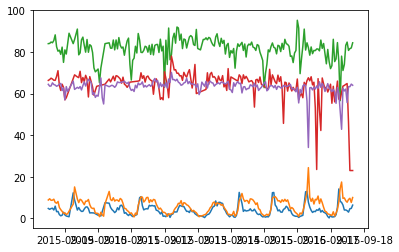

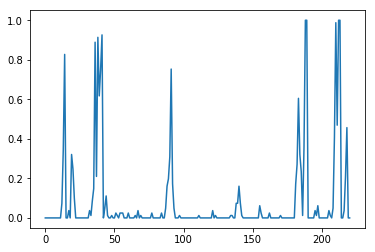

In [24]:
plt.plot(seldata)
plt.figure()
plt.plot(A_score)

### Computes the anomaly likelhood

We are now computing the likelihood that the system is in a current anomalous state, to do so we have to determine 2 windows:
- W: 72 datapoints (three days), computes the normal error distribution
- W_prim: 6 datapoints (6 hours), computes the mean error at the current state

In [25]:
from scipy.stats import norm
W = 72
W_prim = 5
eps = 1e-6

In [26]:
AL_score = np.zeros(len(A_score))
for x in range(len(A_score)):
    if x > 0:
        W_vec = A_score[max(0, x-W): x]
        W_prim_vec = A_score[max(0, x-W_prim): x]
        AL_score[x] = 1 - 2*norm.sf(abs(np.mean(W_vec)-np.mean(W_prim_vec))/max(np.std(W_vec), eps))
    

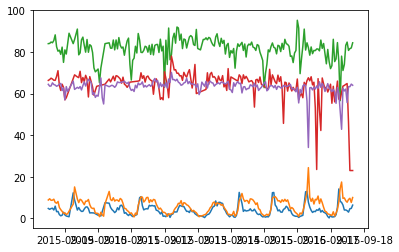

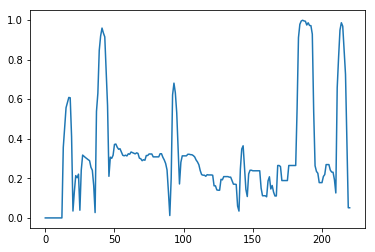

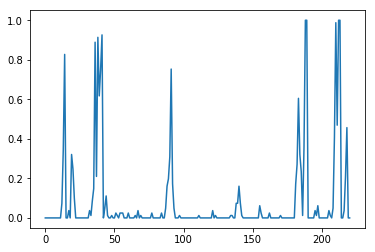

In [27]:
plt.plot(seldata)
plt.figure()
plt.plot(AL_score)
plt.figure()
plt.plot(A_score)